In [567]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
import numpy as np

from model import SimpleConv, SANet
from dataset import SaliencyDataset, process_batch, process_batch_2

In [568]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
LARGE_SIZE = 26
plt.rcParams.update({
    'font.size': MEDIUM_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': LARGE_SIZE,
    'xtick.labelsize': SMALL_SIZE ,
    'ytick.labelsize': SMALL_SIZE ,
    'legend.fontsize': SMALL_SIZE-2,
    'figure.titlesize': LARGE_SIZE,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    'grid.linewidth': 1,
    'grid.linestyle': ':',
    'lines.linewidth': 2,
    'lines.markersize': 6
})

In [569]:
def norm_minmax(x, dim, min_val=None, max_val=None):
    """
    Applies Min-Max Normalization along a specified dimension.
    
    Args:
        x (Tensor): Input tensor.
        dim (int): Dimension along which to compute min/max.
        min_val (Tensor or None): Minimum value (if None, computed from x).
        max_val (Tensor or None): Maximum value (if None, computed from x).
    
    Returns:
        Tensor: Normalized tensor.
    """
    if min_val is None:
        min_val, _ = x.min(dim=dim, keepdim=True)
    if max_val is None:
        max_val, _ = x.max(dim=dim, keepdim=True)
    
    return (x - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero

In [570]:
ckpt_dir = '/mnt/ssd_1tb_sda/subin/worktable/ckpt'
ckpt_list = os.listdir(ckpt_dir)
ckpt_list.sort()
ckpt_list = [ckpt for ckpt in ckpt_list if ckpt.endswith('.pt')]
# ckpt_list = [ckpt for ckpt in ckpt_list if ckpt.endswith('.pth')]

In [571]:
feature_dir = 'output_features'
annotation_dir = 'annotations'
root_dir = 'data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = SaliencyDataset(root_dir, feature_dir, annotation_dir)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda batch: batch)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=lambda batch: batch)

data = next(iter(dataloader))
vid_name=data[0]['video_name']
vid_url=data[0]['url']
data = process_batch_2(data)

In [572]:
from torch import nn

norm = nn.Identity()

yt_highlite_saliency_raw = data['yt_highlite_saliency_raw'].numpy()
moment_detr_saliency_raw = data['moment_detr_saliency_raw'].numpy()

preds = {}
for ckpt in ckpt_list:
    if 'e004' not in ckpt:
        continue
    
    model = torch.load(os.path.join(ckpt_dir, ckpt)).to(device)
    model.eval()
    feature = data['feature'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(feature)
        pred = norm(pred)
        # pred = norm_minmax(pred, 1)
        pred_np = pred.cpu().numpy()
        pred_np = pred_np.squeeze()
        
        preds[ckpt] = pred_np
        
    

In [573]:
# for k in preds.keys():
#     plt.clf()
#     plt.plot(preds[k]-0.5)
#     plt.plot(yt_highlite_saliency_raw-0.5)
#     plt.plot(moment_detr_saliency_raw)
#     plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw'])
#     # plt.plot(((yt_highlite_saliency_raw)*(moment_detr_saliency_raw)+0.5)-0.5)
#     # plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw', 'yt_highlite_saliency_raw*moment_detr_saliency_raw'])
#     plt.title(k)
#     plt.show()

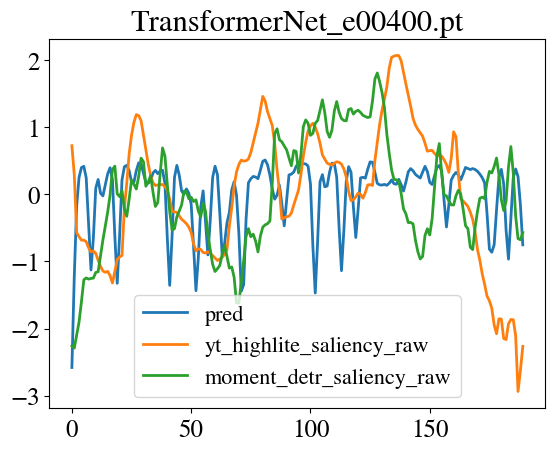

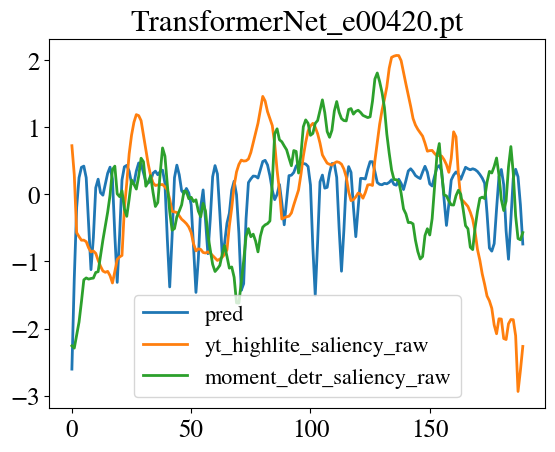

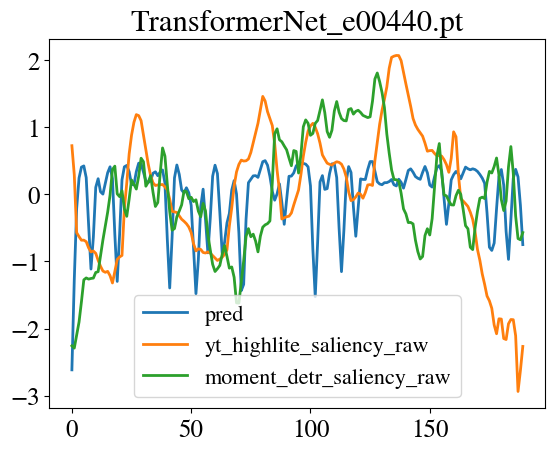

In [574]:
# scipy import smooth filter

from scipy.ndimage import gaussian_filter1d
for k in preds.keys():
    plt.clf()
    
    mean = preds[k].mean()
    std = preds[k].std()
    pred_normalized = (preds[k] - mean) / (std + 1e-8)  # add epsilon to avoid division by zero
    # print(pred_normalized.mean(), pred_normalized.std())
    plt.plot(gaussian_filter1d(pred_normalized, 1))
    # plt.plot(yt_highlite_saliency_raw-0.5)
    # yt_pow = 0.2
    yt_pow = 0.1
    yt_highlite_saliency_raw_pow = yt_highlite_saliency_raw ** yt_pow
    mean = yt_highlite_saliency_raw_pow.mean()
    std = yt_highlite_saliency_raw_pow.std()
    yt_highlite_saliency_raw_normalized = (yt_highlite_saliency_raw_pow - mean) / (std + 1e-8)  # add epsilon to avoid division by zero
    # print(yt_highlite_saliency_raw_normalized.mean(), yt_highlite_saliency_raw_normalized.std())
    # plt.plot(gaussian_filter1d(yt_highlite_saliency_raw_normalized, 3))
    plt.plot(yt_highlite_saliency_raw_normalized)
    
    mean = moment_detr_saliency_raw.mean()
    std = moment_detr_saliency_raw.std()
    moment_detr_saliency_raw_normalized = (moment_detr_saliency_raw - mean) / (std + 1e-8)  # add epsilon to avoid division by zero
    # print(moment_detr_saliency_raw_normalized.mean(), moment_detr_saliency_raw_normalized.std())
    plt.plot(gaussian_filter1d(moment_detr_saliency_raw_normalized, 1))
    # plt.plot(moment_detr_saliency_raw_normalized)
    plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw'])
    # plt.plot(((yt_highlite_saliency_raw)*(moment_detr_saliency_raw)+0.5)-0.5)
    # plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw', 'yt_highlite_saliency_raw*moment_detr_saliency_raw'])
    plt.title(k)
    plt.show()

In [575]:
# # scipy import smooth filter

# from scipy.ndimage import gaussian_filter1d
# plt.clf()
# mean = yt_highlite_saliency_raw.mean()
# std = yt_highlite_saliency_raw.std()
# yt_highlite_saliency_raw_normalized = (yt_highlite_saliency_raw - mean) / (std + 1e-8)  # add epsilon to avoid division by zero

# plt.plot(gaussian_filter1d(yt_highlite_saliency_raw, 5))

# mean = moment_detr_saliency_raw.mean()
# std = moment_detr_saliency_raw.std()
# moment_detr_saliency_raw_normalized = (moment_detr_saliency_raw - mean) / (std + 1e-8)  # add epsilon to avoid division by zero

# plt.plot(gaussian_filter1d(moment_detr_saliency_raw_normalized, 5))
# plt.legend(['yt_highlite_saliency_raw', 'moment_detr_saliency_raw'])


# for k in preds.keys():
    
    
#     mean = preds[k].mean()
#     std = preds[k].std()
#     pred_normalized = (preds[k] - mean) / (std + 1e-8)  # add epsilon to avoid division by zero
#     # print(pred_normalized.mean(), pred_normalized.std())
#     plt.plot(gaussian_filter1d(pred_normalized, 5))
#     # plt.plot(yt_highlite_saliency_raw-0.5)
    
#     # plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw'])
#     # plt.plot(((yt_highlite_saliency_raw)*(moment_detr_saliency_raw)+0.5)-0.5)
#     # plt.legend(['pred', 'yt_highlite_saliency_raw', 'moment_detr_saliency_raw', 'yt_highlite_saliency_raw*moment_detr_saliency_raw'])
#     plt.title(k)
# plt.show()

In [576]:
pred_np = preds['TransformerNet_e00440.pt']
# pred_np = preds['model_TransformerNet_feat256_hid512_SA2_heads4_dropout0.1_bs8_normnone_epoch1500.pth']
pred_np = gaussian_filter1d(pred_np, 1)

len_f = pred_np.shape[0]
top_k = round(len_f * 0.10)

# Get indices of top 10% values
topk_indices = np.argpartition(pred_np, -top_k)[-top_k:]

# Optional: sort the top indices by value (descending)
topk_indices_sorted = topk_indices[np.argsort(pred_np[topk_indices])[::-1]]
topk_indices_sorted.sort()
highlite_ours = topk_indices_sorted.copy()
topk_indices_sorted, len(topk_indices_sorted)*2, len_f*2
highlite_ours_val = pred_np[topk_indices_sorted]

In [577]:
pred_np = yt_highlite_saliency_raw
# pred_np = gaussian_filter1d(pred_np, 3)

len_f = pred_np.shape[0]
top_k = round(len_f * 0.10)

# Get indices of top 10% values
topk_indices = np.argpartition(pred_np, -top_k)[-top_k:]

# Optional: sort the top indices by value (descending)
topk_indices_sorted = topk_indices[np.argsort(pred_np[topk_indices])[::-1]]
topk_indices_sorted.sort()
highlite_yt = topk_indices_sorted.copy()
topk_indices_sorted, len(topk_indices_sorted)*2, len_f*2
highlite_yt_val = pred_np[topk_indices_sorted]

In [578]:
pred_np = moment_detr_saliency_raw
# pred_np = gaussian_filter1d(pred_np, 1)

len_f = pred_np.shape[0]
top_k = round(len_f * 0.10)

# Get indices of top 10% values
topk_indices = np.argpartition(pred_np, -top_k)[-top_k:]

# Optional: sort the top indices by value (descending)
topk_indices_sorted = topk_indices[np.argsort(pred_np[topk_indices])[::-1]]
topk_indices_sorted.sort()
highlite_moment_detr = topk_indices_sorted.copy()
topk_indices_sorted, len(topk_indices_sorted)*2, len_f*2
highlite_moment_detr_val = pred_np[topk_indices_sorted]

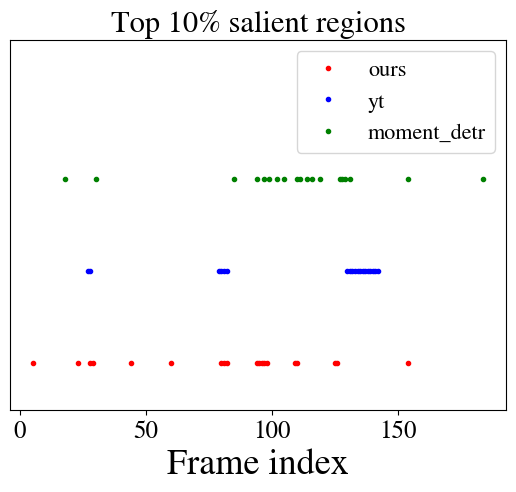

In [579]:
plt.clf()
plt.plot(highlite_ours, np.ones_like(highlite_ours), 'ro', markersize=3)
plt.plot(highlite_yt, np.ones_like(highlite_yt)*1.1, 'bo', markersize=3)
plt.plot(highlite_moment_detr, np.ones_like(highlite_moment_detr)*1.2, 'go', markersize=3)
plt.legend(['ours', 'yt', 'moment_detr'])
# remove y-axis
plt.yticks([])
# plt.xticks([])
# set x-axis name
plt.xlabel('Frame index')
# ylim 4
plt.ylim(0.95, 1.35)
plt.title('Top 10% salient regions')
plt.show()

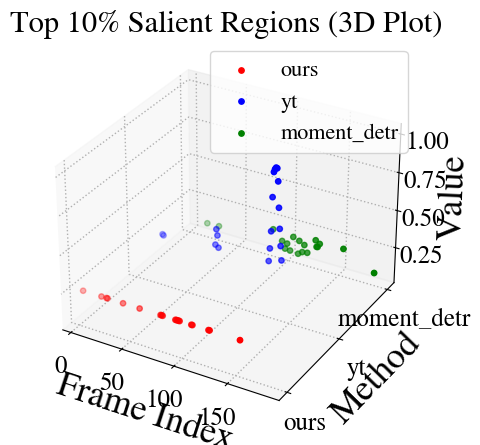

In [580]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# z-axis: value
z_ours = highlite_ours_val
z_yt = highlite_yt_val
z_moment = highlite_moment_detr_val

# x-axis: frame index
x_ours = highlite_ours
x_yt = highlite_yt
x_moment = highlite_moment_detr

# y-axis: category label (fixed values to separate)
y_ours = np.ones_like(x_ours) * 0
y_yt = np.ones_like(x_yt) * 1
y_moment = np.ones_like(x_moment) * 2

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_ours, y_ours, z_ours, c='r', label='ours', s=15)
ax.scatter(x_yt, y_yt, z_yt, c='b', label='yt', s=15)
ax.scatter(x_moment, y_moment, z_moment, c='g', label='moment_detr', s=15)

# Aesthetic tweaks
ax.set_xlabel('Frame Index')
ax.set_ylabel('Method')
ax.set_zlabel('Value')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['ours', 'yt', 'moment_detr'])
ax.set_title('Top 10% Salient Regions (3D Plot)')
ax.legend()
# plt.tight_layout()
plt.show()


6minutesofrogerfedererexemplarysportsmanship
https://www.youtube.com/watch?v=qeZ1RhD_OeY


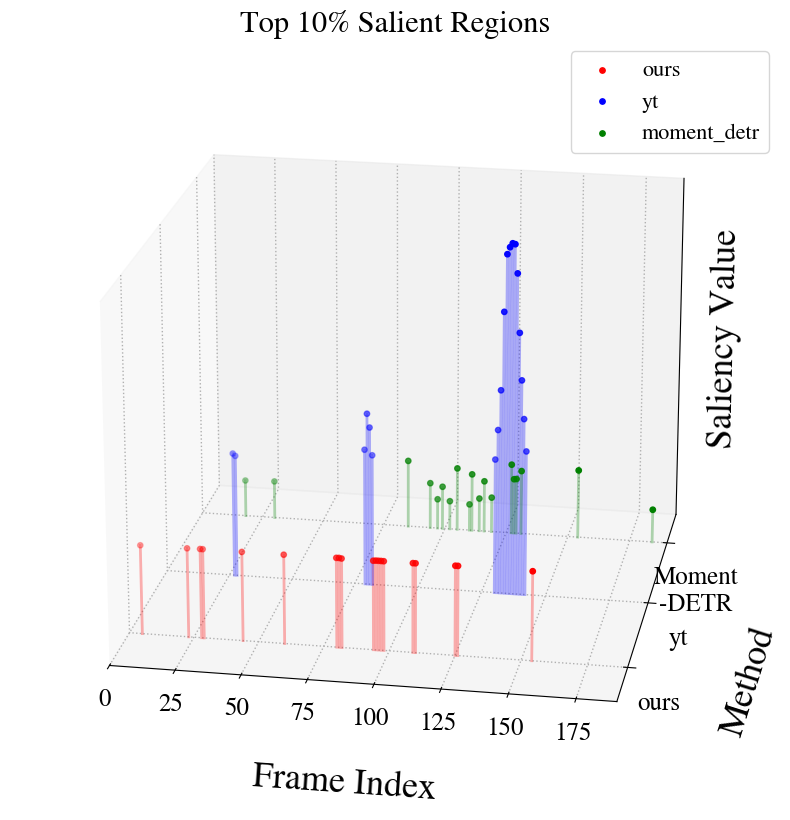

In [581]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# z-axis: value
z_ours = highlite_ours_val
z_yt = highlite_yt_val
z_moment = highlite_moment_detr_val

# x-axis: frame index
x_ours = highlite_ours
x_yt = highlite_yt
x_moment = highlite_moment_detr

# y-axis: method index
y_ours = np.ones_like(x_ours) * 0
y_yt = np.ones_like(x_yt) * 1
y_moment = np.ones_like(x_moment) * 2

# Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
ax.scatter(x_ours, y_ours, z_ours, c='r', label='ours', s=15)
ax.scatter(x_yt, y_yt, z_yt, c='b', label='yt', s=15)
ax.scatter(x_moment, y_moment, z_moment, c='g', label='moment_detr', s=15)

# Add lines from (x, y, 0) to (x, y, z)
for x, y, z in zip(x_ours, y_ours, z_ours):
    ax.plot([x, x], [y, y], [0, z], color='r', alpha=0.3)

for x, y, z in zip(x_yt, y_yt, z_yt):
    ax.plot([x, x], [y, y], [0, z], color='b', alpha=0.3)

for x, y, z in zip(x_moment, y_moment, z_moment):
    ax.plot([x, x], [y, y], [0, z], color='g', alpha=0.3)

# Axes labels
ax.set_xlabel('Frame Index', labelpad=30)
ax.set_xlim(0, len_f)
ax.set_ylabel('Method', labelpad=40)
ax.set_ylim(-0.5, 2.5)
ax.set_zlabel('Saliency Value')
ax.set_zlim(0, 1)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['ours', 'yt', 'Moment\n-DETR'])
ax.yaxis.set_tick_params(pad=10)  # 기본은 pad=4, 숫자를 키우면 오른쪽으로 이동
ax.set_zticks([])
ax.set_title('Top 10% Salient Regions')
ax.legend()
# ax.view_init(elev=30, azim=45)
# ax.view_init(elev=90, azim=-90)
ax.view_init(elev=20, azim=-80)
# ax.view_init(elev=20, azim=120)

# plt.tight_layout()
print(vid_name)
print(vid_url)
plt.show()
save_path = 'top_10_percent_salient_regions.png'
fig.savefig(save_path, bbox_inches="tight", pad_inches=0.3, transparent=True, dpi=300)